### Load the image file

In [1]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage import io, color
from skimage.morphology import black_tophat, disk
from skimage import measure, morphology
from skimage.measure import label, regionprops
from skimage.exposure import equalize_adapthist
from skimage.filters import threshold_local
from skimage.morphology import skeletonize, binary_dilation
from scipy.ndimage import convolve
import warnings
warnings.filterwarnings("ignore")

# Local folder address where the file is stored
data_folder = 'E:\\Spandan'
file_name = 'image001'

image = io.imread(data_folder+'\\'+file_name+'.png') 

if image.ndim == 3:
    # gray_im = color.rgb2gray(image)  # if we want to choose the grayscale version instead
    gray_im = image[:,:,2];      # we chose the blue color channel since it has the clearest vessel structure
else:
    gray_im = image
    

### Visualize the image file

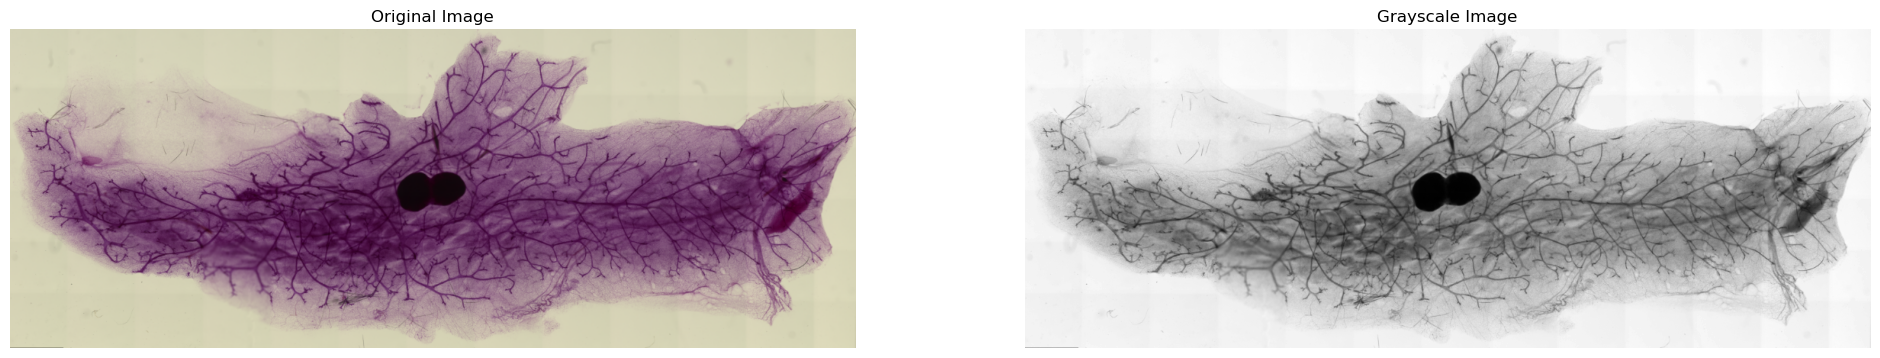

In [2]:
plt.figure(figsize=(24, 9))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Grayscale Image')
plt.imshow(gray_im, cmap='gray')
plt.axis('off')

plt.show()

### CLAHE (Contrast Limited Adaptive Histogram Equalization)
In order to increase contrast without over-amplifying noise

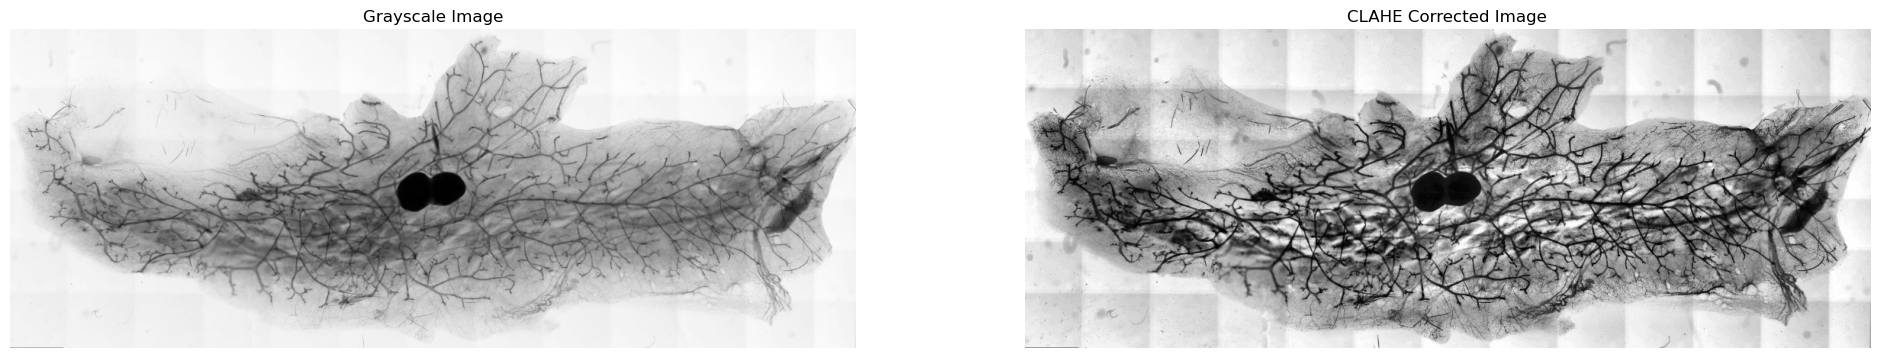

In [3]:
# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe_corrected = equalize_adapthist(gray_im, clip_limit=0.03)

plt.figure(figsize=(24, 9))
plt.subplot(1, 2, 1)
plt.title('Grayscale Image')
plt.imshow(gray_im, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('CLAHE Corrected Image')
plt.imshow(clahe_corrected, cmap='gray')
plt.axis('off')

plt.show()

### Tophat filtering to extract small features 
We use black tophat since the background is white and the features are black

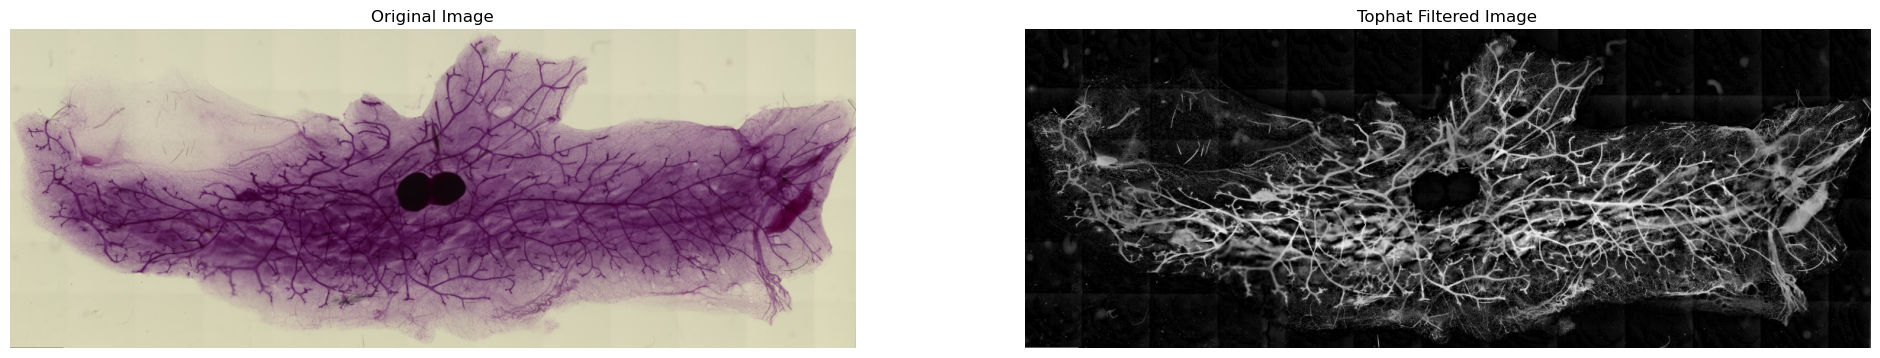

In [18]:
# Create a ball-shaped structuring element
str_elem = disk(radius=15)

# Apply the black tophat filter with the structuring element
corrected_tphat = black_tophat(clahe_corrected, str_elem)

plt.figure(figsize=(24, 9))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Tophat Filtered Image')
plt.imshow(corrected_tphat, cmap='gray')
plt.axis('off')

plt.show()


### Visualize a cropped region to get an idea of the vessel widths

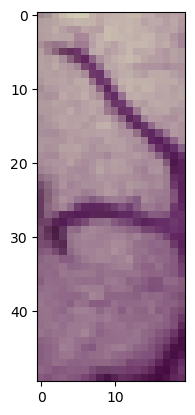

In [5]:
plt.imshow(image[120:170,430:450])

Seems like a a few pixels wide

### Adaptive thresholding to correct non-uniform illumination

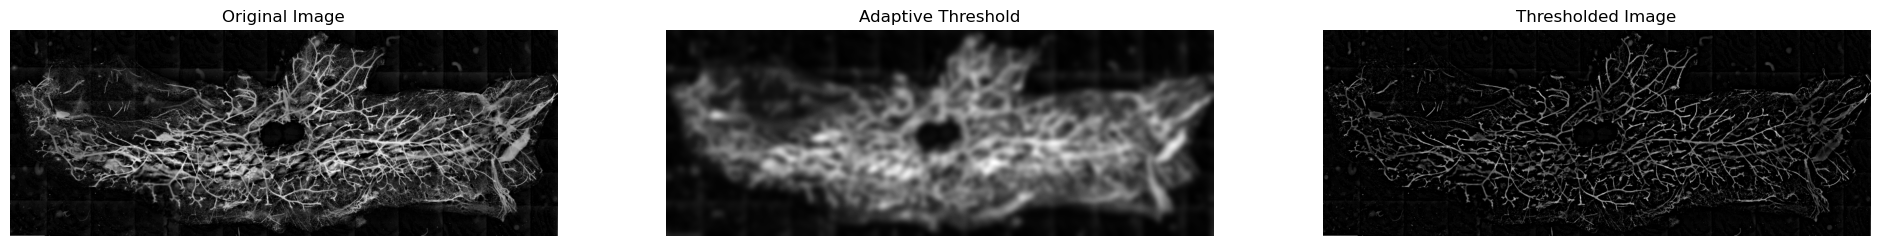

In [19]:
# Apply adaptive (local) thresholding
block_size = 35
adaptive_thresh = threshold_local(corrected_tphat, block_size, offset=0.01)

# Subtract the background estimated by adaptive thresholding
adapt_corrected = corrected_tphat - adaptive_thresh

# Clip any negative values to zero
adapt_corrected[adapt_corrected < 0] = 0

plt.figure(figsize=(24, 9))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(corrected_tphat, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adaptive Threshold')
plt.imshow(adaptive_thresh, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Thresholded Image')
plt.imshow(adapt_corrected, cmap='gray')
plt.axis('off')

plt.show()

### Extracting the raw mask from the final image
We are choosing the top 10 percentile of pixel intensities for our masking.

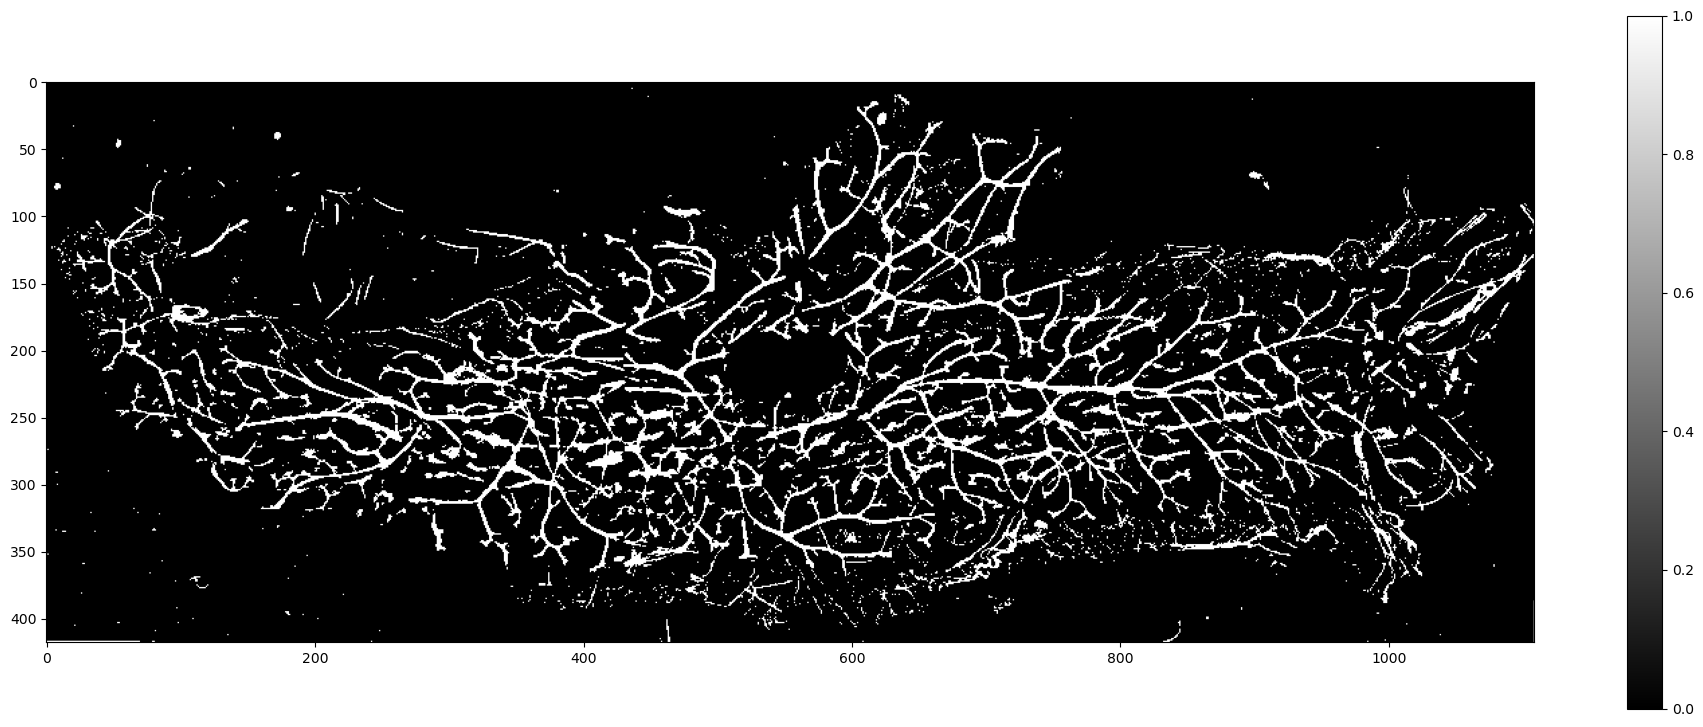

In [20]:
threshold = 90   # percentile for pixel intensity thresholding
im_mask = adapt_corrected > np.percentile(adapt_corrected,90)

plt.figure(figsize=(24, 9))
plt.imshow(im_mask, cmap='gray'); plt.colorbar()

### Get the largest connected components from the raw mask and skeletonize it

In [21]:
def get_largest_components(binary_mask, n):

    # Label connected components
    labeled_mask, num_features = label(binary_mask, return_num=True, connectivity=2)
    
    # Extract properties of labeled regions
    properties = regionprops(labeled_mask)
    
    # Sort regions by area (size) in descending order
    sorted_regions = sorted(properties, key=lambda x: x.area, reverse=True)
    
    # Create an empty mask for the largest components
    largest_components_mask = np.zeros_like(binary_mask)
    
    # Iterate over the top n regions and add them to the mask
    for i in range(min(n, len(sorted_regions))):
        largest_components_mask[labeled_mask == sorted_regions[i].label] = 1
   
    return largest_components_mask

def skeletonize_component(binary_mask, n):

    largest_component = get_largest_components(binary_mask,n)  # Get the largest connected component
    skeleton = morphology.skeletonize(largest_component)       # Skeletonize the largest component   
    
    return skeleton

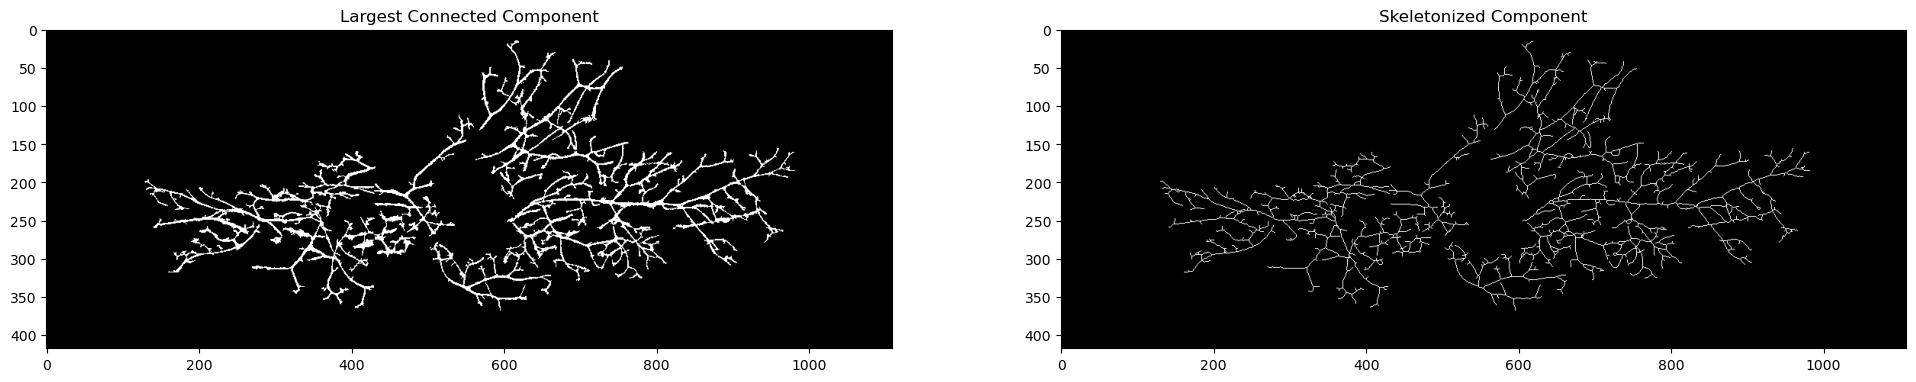

In [22]:
# Get the largest n connected components
n = 5   
# need to change this slightly depending on the image or rather put an area threshold

largest_components = get_largest_components(im_mask, n)
skeleton = skeletonize_component(im_mask, n)   # Skeletonize the largest connected component

# Display the original, largest component, and skeletonized images
fig, ax = plt.subplots(1, 2, figsize=(24, 9))

ax[0].imshow(get_largest_components(im_mask,n), cmap='gray')
ax[0].set_title('Largest Connected Component')
ax[1].imshow(skeleton, cmap='gray')
ax[1].set_title('Skeletonized Component')

plt.show()

### Find the number of branching points, endpoints, branches (from the skeleton)

In [23]:
# Define a convolution kernel to find neighbors
kernel = np.array([[1, 1, 1],
                   [1, 10, 1],
                   [1, 1, 1]])

convolved = convolve(skeleton.astype(int), kernel)  # Convolve the skeleton image with the kernel
branch_points = (convolved >= 13) & skeleton        # Identify branch points (convolution result >= 13)
endpoints = (convolved == 11) & skeleton           # Identify endpoints (convolution result == 11)

# Label the Skeleton
labeled_skeleton = label(skeleton)

# Function to highlight branches with unique colors, count them, and store branch coordinates
# we are discounting any branches below 10 pixels length 

def highlight_and_count_unique_branches(labeled_skeleton, branch_points, endpoints, min_length):
    output_image = np.zeros((*labeled_skeleton.shape, 3), dtype=np.uint8)  # RGB image to visualize colored branches
    branch_colors = {}  # Store colors for each branch
    visited = np.zeros_like(labeled_skeleton, dtype=bool)
    branch_id = 1
    branch_count = 0     
    branch_coordinates = []  # To store coordinates of each branch
    branch_lengths = []  # To store lengths of each branch

    for region in regionprops(labeled_skeleton):
        coords = region.coords
        branch_start = None
        branch_length = 0
        path_coords = []

        # Trace each branch from branch points to endpoints or other branch points
        for coord in coords:
            if branch_points[coord[0], coord[1]] or endpoints[coord[0], coord[1]]:
                if branch_start is not None and branch_length >= min_length:
                    # Save the current branch path
                    color = [random.randint(0, 255) for _ in range(3)]
                    branch_colors[branch_id] = color
                    for p in path_coords:
                        output_image[p[0], p[1]] = color
                        visited[p[0], p[1]] = True
                    branch_id += 1
                    branch_count += 1
                    branch_coordinates.append(path_coords)  # Store coordinates for width calculation
                    branch_lengths.append(branch_length)  # Store length of the current branch

                # Start a new branch
                branch_start = coord
                branch_length = 0
                path_coords = [coord]
            elif branch_start is not None:
                # Continue tracing the current branch
                path_coords.append(coord)
                branch_length += 1

    return output_image, branch_count, branch_coordinates, branch_lengths


colored_branches, num_branches, branch_coords, branch_lengths = highlight_and_count_unique_branches(
    labeled_skeleton, branch_points, endpoints, min_length=10)

### Calculate branch widths by mapping the skeletonized branches to the actual vessels

In [26]:
def calculate_branch_widths(branch_coords, binary_mask):
    branch_widths = []

    for branch in branch_coords:
        # Create a mask for the current branch
        branch_mask = np.zeros_like(binary_mask)
        for coord in branch:
            branch_mask[coord[0], coord[1]] = 1

        # Calculate the bounding box of the branch
        coords = np.array(branch)
        min_row, min_col = np.min(coords, axis=0)
        max_row, max_col = np.max(coords, axis=0)

        # Measure the width within the bounding box
        branch_width = 0
        for col in range(min_col, max_col + 1):
            column_sum = np.sum(binary_mask[min_row:max_row + 1, col])
            branch_width = max(branch_width, column_sum)

        branch_widths.append(branch_width)

    return branch_widths

### Print the number of branches, branching points, and end points

In [27]:
# Calculate branch widths
branch_widths = calculate_branch_widths(branch_coords, im_mask)

# Save widths and lengths to arrays
branch_widths_array = np.array(branch_widths)
branch_lengths_array = np.array(branch_lengths)

n_branch_points = len(np.where(branch_points==True)[0])
n_end_points = len(np.where(endpoints==True)[0])

# Print the number of unique branches, branching points and end points
print(f"Number of unique branches (length >= 10 pixels): {num_branches}")
print(f"Number of branching points: {n_branch_points}")
print(f"Number of end points: {n_end_points}")


Number of unique branches (length >= 10 pixels): 198
Number of branching points: 1983
Number of end points: 457


### Visualizing the individual branches

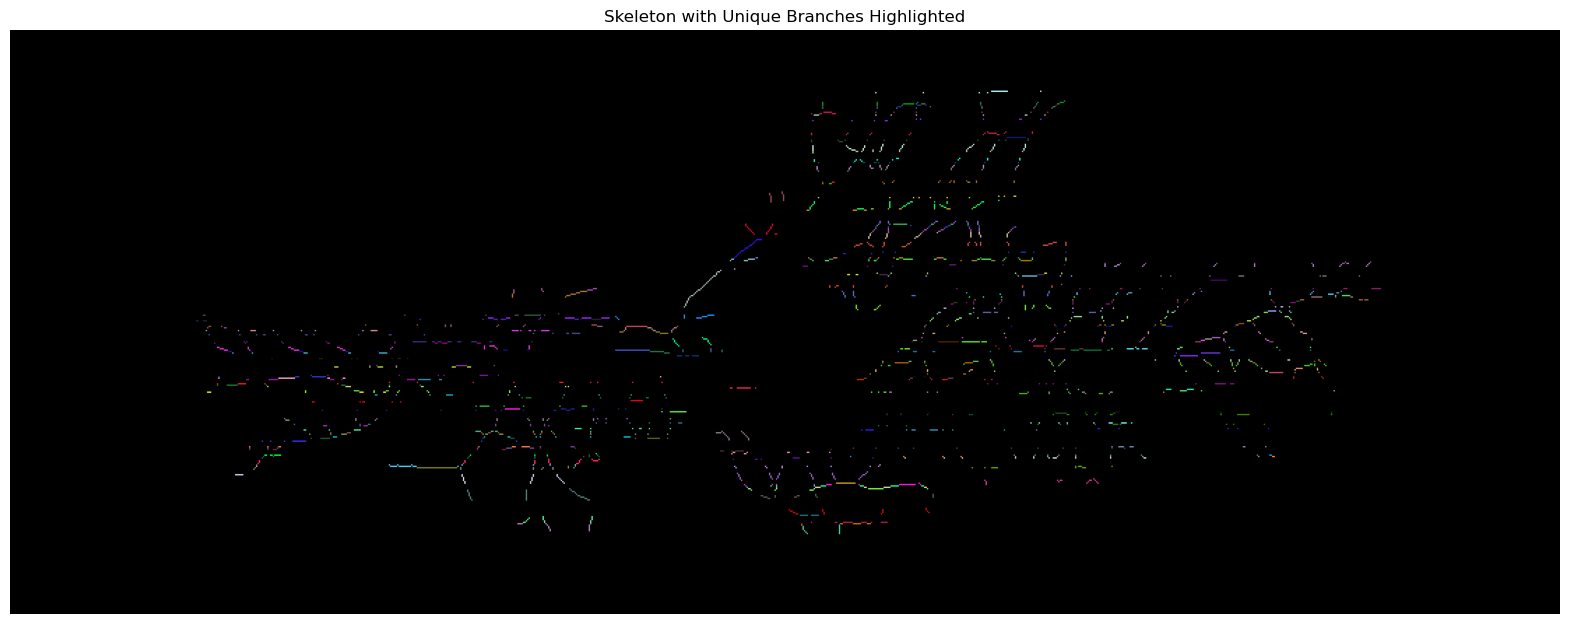

In [28]:
plt.figure(figsize=(20, 10))
plt.imshow(colored_branches)
plt.title('Skeleton with Unique Branches Highlighted')
plt.axis('off')
plt.show()


### Visualizing the branching points and end points

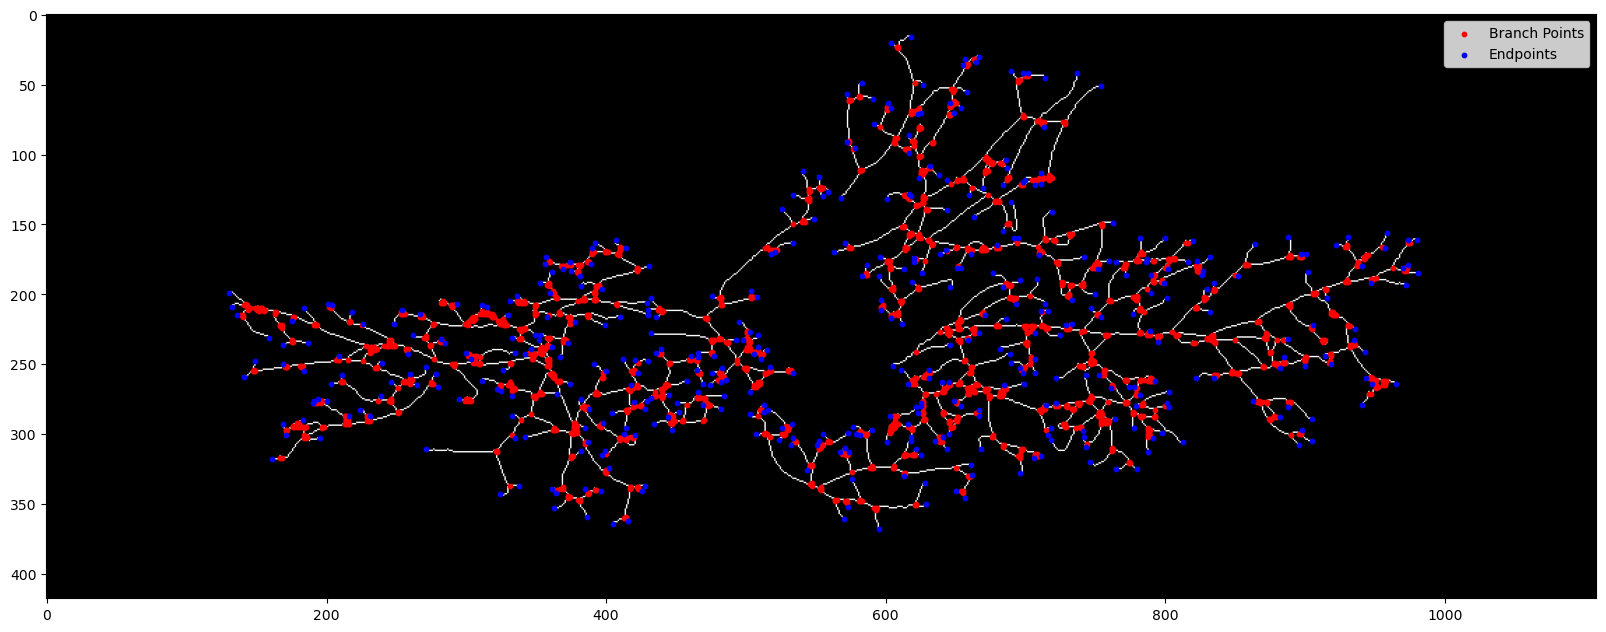

In [29]:
plt.figure(figsize=(20, 10))
plt.imshow(skeleton, cmap='gray')
plt.scatter(np.where(branch_points)[1], np.where(branch_points)[0], color='red', s=10, label='Branch Points')
plt.scatter(np.where(endpoints)[1], np.where(endpoints)[0], color='blue', s=10, label='Endpoints')
plt.legend()
plt.show()

### Distribution of the vessel widths

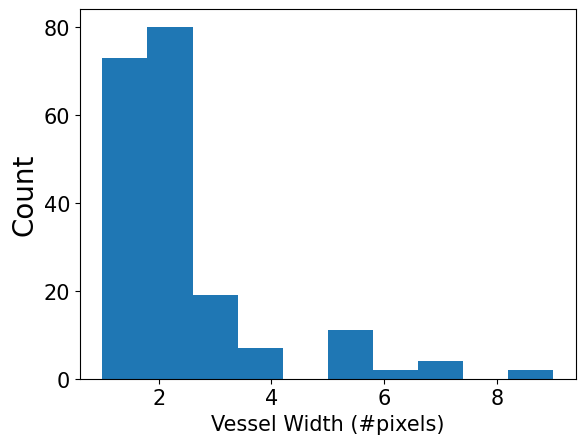

In [30]:
plt.hist(branch_widths_array)
plt.xlabel('Vessel Width (#pixels)',fontsize="15")
plt.ylabel('Count',fontsize="20")
plt.tick_params(axis='both', which='major', labelsize=15)

### Distribution of the vessel lengths

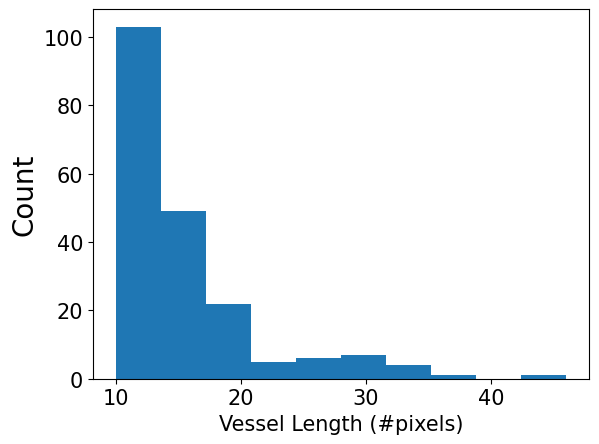

In [31]:
plt.hist(branch_lengths_array)
plt.xlabel('Vessel Length (#pixels)',fontsize="15")
plt.ylabel('Count',fontsize="20")
plt.tick_params(axis='both', which='major', labelsize=15)

### Print mean length and width of the vessels

In [33]:
mean_length = np.mean(branch_lengths_array)
mean_width = np.mean(branch_widths_array)

print(f"Mean Length: {mean_length} pixels")
print(f"Mean Width: {mean_width} pixels")

Mean Length: 15.171717171717171 pixels
Mean Width: 2.176767676767677 pixels
